This notebook is to fragment that satellite images into 64x64 chunks, then run them through the LULC model.

# Library imports

In [33]:
!pip install torchvision

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns
import random
import re


from sklearn.metrics import confusion_matrix
from sklearn import model_selection


import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib
matplotlib.rcParams['axes.grid'] = False


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Constant settings

In [34]:
# will only process these volcanoes

VOLC_LIST = ['Fournaise', 'Sinabung', 'Kilauea', 'Soufriere', 'Rincon', 'Turrialba','San Cristobal','Telica']



In [35]:
#connect to google drive
from google.colab import drive  

# drive roots
DRIVE_MOUNT = '/content/drive'
drive.mount(DRIVE_MOUNT, force_remount=True)

EUROSAT_ROOT_PATH = DRIVE_MOUNT+'/My Drive/EuroSat/'
MODELS_DIR = EUROSAT_ROOT_PATH + 'models'
IMAGE_ROOT = DRIVE_MOUNT+'/My Drive/Full_year_landsat9'
FRAGMENT_DIR = IMAGE_ROOT+'/Fragments'

FRAGMENT_CSV = IMAGE_ROOT +"/LULC_fragments.csv"

OUTPUT_CSV = IMAGE_ROOT + "/LULC_estimates.csv"

OUTPUT_SHP_FILE = IMAGE_ROOT + "/LULC_estimates.shp"

Mounted at /content/drive


In [36]:
# Model to use for predictions

MODEL_TO_USE = MODELS_DIR + "/master_lulc_model.pth"

# do we need to do fragmenting? or use those already made?
FRAGMENTING = True


# Fragment Images
Read image files and write into 64x64 fragments, removing axes

In [37]:
def display_image(img):
  fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
  ax.imshow(img)
  plt.show()

In [38]:
def fragment_image(image_source, image_dir, output_dir):

  rgb2xyz = (
    0.412453, 0.357580, 0.180423, 0,
    0.212671, 0.715160, 0.072169, 0,
    0.019334, 0.119193, 0.950227, 0)
  # read image
  with Image.open(image_dir + "/"+image_source) as img_file:
    img = img_file.convert("RGB")
    display_image(img)

    tile_file_list = []
    
    # remove the file type from filename
    filename_base = (image_source).split(".")[0]

    # tile into 64x64 hunks
    nx, ny = img.size
    c_x = np.ceil(nx/64) # number of chunks in the x direction
    x_step = np.floor(nx/c_x)
    c_y = np.ceil(ny/64) # number of chunks in the y direction
    y_step = np.floor(ny/c_y)
    for ix in range(int(c_x)):
      for iy in range (int(c_y)):
        # crop out a chunk
        left = ix * x_step
        right = left + 64
        upper = iy * y_step
        lower = upper + 64
        #print("x:",ix,c_x, x_step,left,right)
        #print("y:",iy,c_y, y_step,upper,lower)
        img_crop = img.crop((left,upper,right,lower))
      # write tiles to output dir
        frag_filename = f'{FRAGMENT_DIR}/{filename_base}_{int(left)}_{int(upper)}.jpg'
        #print(f'writing {frag_filename}')
        img_crop.save(frag_filename)
        tile_file_list.append(frag_filename)

  df = pd.DataFrame(tile_file_list,columns=["image_id"])
  return(df)

Fragmenting image: Fournaise_Piton_de_la_2020_233020_rgb.png


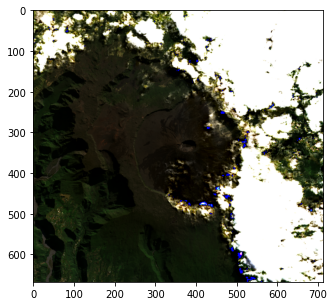

Fragmenting image: Kilauea_2020_332010_rgb.png


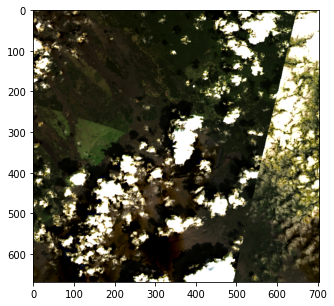

Fragmenting image: Soufriere_St_Vincent_2020_360150_rgb.png


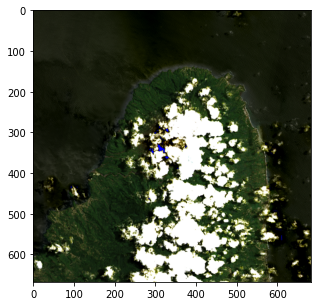

Fragmenting image: Telica_2020_344040_rgb.png


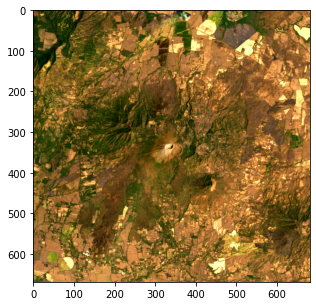

writing /content/drive/My Drive/Full_year_landsat9/LULC_fragments.csv
                                              image_id    label
0    /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
1    /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
2    /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
3    /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
4    /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
..                                                 ...      ...
490  /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
491  /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
492  /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
493  /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake
494  /content/drive/My Drive/Full_year_landsat9/Fra...  SeaLake

[495 rows x 2 columns]


In [39]:
# get list of images in directory

source_image_list = os.listdir(IMAGE_ROOT)

fragment_df = pd.DataFrame({"image_id":[],"label":[]})

if FRAGMENTING: 
  for volc in VOLC_LIST:
    # find files for this volcano
    regex_pattern =  volc + ".*"
    for src_img_file in source_image_list:
      # does it match this volcano?
      if re.match(regex_pattern, src_img_file):
        print(f'Fragmenting image: {src_img_file}')
        fragment_df = fragment_df.append(fragment_image(src_img_file,IMAGE_ROOT,FRAGMENT_DIR), ignore_index=True)
  
  print(f'writing {FRAGMENT_CSV}')
  # fake label everything as sealake, we should not use these anyway
  fragment_df = fragment_df.assign(label='SeaLake')
  fragment_df.to_csv(FRAGMENT_CSV)
else:
  fragment_df = pd.read_csv(FRAGMENT_CSV)
                            
print(fragment_df)

# Set up the model

This is all taken from the LULC_modified_resnet50.ipynb script

## Config

In [40]:


IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(1021)
TEST_SIZE = 0.25

approach = "Resnet"

## Utils

In [41]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [42]:
class EuroSAT(Dataset):
    def __init__(self, df, transform=None):
        self.train_df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(img_id)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

In [43]:
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                ])

In [44]:
eval_ds = EuroSAT(fragment_df, data_transform)

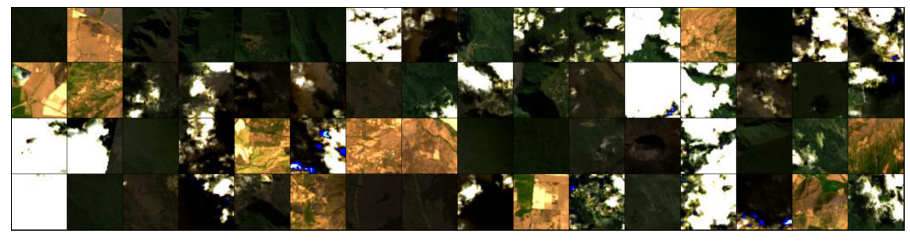

In [45]:
## Data loaders and showing batch of data
batch_size = 64
eval_dl = DataLoader(eval_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
show_batch(eval_dl)

## Initializing Device also Loading Data and Model to device

In [46]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

## Model setup

In [47]:
## Hyper Parameters
max_epochs_stop = 5
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 0
batch_size = 64
criterion = nn.CrossEntropyLoss()
opt_func = torch.optim.Adam

In [48]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss

    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [49]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [50]:
device = get_device()
## Loading data to devide
batch_size =1
eval_dl = DataLoader(eval_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
eval_dl = DeviceDataLoader(eval_dl, device)

True


In [51]:
model = LULC_Model()
model.load_state_dict(torch.load(MODEL_TO_USE))
model.eval()
model = to_device(model, device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
        
try_batch(eval_dl)

torch.Size([1, 3, 224, 224])
torch.Size([1, 10])
tensor([-1.9603e+01, -2.2004e+01, -3.5763e-07, -1.9908e+01, -1.4769e+01,
        -2.2995e+01, -2.0273e+01, -2.3662e+01, -2.1846e+01, -2.4158e+01],
       device='cuda:0', grad_fn=<SelectBackward0>)


# Run model

In [53]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [54]:
predictions, labels = predict_dl(eval_dl, model)
fragment_df['label'] = [IDX_CLASS_LABELS[x.item()] for x in predictions]



  0%|          | 0/495 [00:00<?, ?it/s]

In [55]:
print (fragment_df)

                                              image_id                 label
0    /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
1    /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
2    /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
3    /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
4    /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
..                                                 ...                   ...
490  /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
491  /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
492  /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
493  /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation
494  /content/drive/My Drive/Full_year_landsat9/Fra...  HerbaceousVegetation

[495 rows x 2 columns]


# Save output dataframe

In [57]:
fragment_df.to_csv(OUTPUT_CSV,index=False)
print(OUTPUT_CSV + " written")

/content/drive/My Drive/Full_year_landsat9/LULC_estimates.csv written
